In [68]:
import torch
import torch.nn as nn
import numpy as np
from transformers import ViTModel, ViTFeatureExtractor

class SegmentationModel(nn.Module):
    def __init__(self, backbone_name, num_classes):
        super(SegmentationModel, self).__init__()
        self.backbone = ViTModel.from_pretrained(backbone_name)
        
        # Assuming the image size is 224x224 and patch size is 16x16
        self.num_patches = (224 // 16) * (224 // 16)
        self.patch_size = 16
        
        # Additional layers for segmentation
        self.segmentation_head = nn.Sequential(
            nn.Conv2d(self.backbone.config.hidden_size, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, num_classes, kernel_size=1)
        )
        
    def forward(self, pixel_values):
        outputs = self.backbone(pixel_values=pixel_values)
        hidden_states = outputs.last_hidden_state
        
        # Remove the CLS token
        hidden_states = hidden_states[:, 1:, :]
        
        # Reshape hidden_states for Conv2d layer
        batch_size, num_patches, hidden_dim = hidden_states.size()
        height = width = int(num_patches ** 0.5)
        assert height * width == num_patches, "The number of patches should be a perfect square"
        hidden_states = hidden_states.permute(0, 2, 1).reshape(batch_size, hidden_dim, height, width)
        
        x = self.segmentation_head(hidden_states)
        return x

# Example usage
model = SegmentationModel("google/vit-base-patch16-224-in21k", num_classes=21)
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

# Dummy input
inputs = feature_extractor(images=[np.random.rand(224, 224, 3)], return_tensors="pt")
outputs = model(inputs['pixel_values'])
print(outputs.shape)


/Users/anisr/Documents/TreeSeg/venv/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


torch.Size([1, 21, 14, 14])


In [ ]:
import os
import torch
import argparse

from treemort.utils.config import setup
from treemort.utils.callbacks import build_callbacks

from treemort.data.dataset import prepare_datasets

from treemort.modeling.builder import resume_or_load
from treemort.modeling.trainer import trainer
from treemort.evaluation.evaluator import evaluator


def run(conf, eval_only):
    assert os.path.exists(
        conf.data_folder
    ), f"Data folder {conf.data_folder} does not exist."

    if not os.path.exists(conf.output_dir):
        os.makedirs(conf.output_dir)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_dataset, val_dataset, test_dataset = prepare_datasets(conf.data_folder, conf)

    model, optimizer, criterion, metrics = resume_or_load(conf, device=device)

    n_batches = len(train_dataset)

    callbacks = build_callbacks(n_batches, conf.output_dir, optimizer)

    if eval_only:
        print("Evaluation-only mode started.")

        evaluator(
            model,
            dataset=test_dataset,
            num_samples=len(test_dataset),
            batch_size=conf.test_batch_size,
            threshold=conf.threshold,
            device=device,
        )

    else:
        print("Training mode started.")

        trainer(
            model,
            optimizer=optimizer,
            criterion=criterion,
            metrics=metrics,
            train_loader=train_dataset,
            val_loader=val_dataset,
            conf=conf,
            callbacks=callbacks,
            device=device,
        )


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Configuration setup for network.")
    parser.add_argument("config", type=str, help="Path to the configuration file")
    parser.add_argument(
        "--eval-only",
        action="store_true",
        help="If set, only evaluate the model without training",
    )

    args = parser.parse_args()

    conf = setup(args.config)

    run(conf, args.eval_only)


In [2]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import random

class DeadTreeDataset(Dataset):
    def __init__(self, root_dir, subset='Train', transform=None):
        self.root_dir = root_dir
        self.subset = subset
        self.transform = transform
        
        if self.subset in ['Train', 'Validation']:
            self.images_dir = os.path.join(root_dir, 'Train', 'Images')
            self.labels_dir = os.path.join(root_dir, 'Train', 'Labels')
        elif self.subset == 'Test':
            self.images_dir = os.path.join(root_dir, 'Test', 'Images')
            self.labels_dir = os.path.join(root_dir, 'Test', 'Labels')
        else:
            raise ValueError("subset should be either 'Train', 'Validation', or 'Test'")
        
        self.image_filenames = os.listdir(self.images_dir)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.image_filenames[idx])
        label_name = os.path.join(self.labels_dir, self.image_filenames[idx])

        # Load image (assuming it's a .npy file with 4 channels)
        image = np.load(img_name)
        # Normalize image to range [0, 1] (assuming it's in [0, 255])
        image = image.astype(np.float32) / 255.0

        # Load label (assuming it's a .npy file)
        label = np.load(label_name)

        # Crop to a fixed size (256x256)
        crop_size = 256
        image, label = self.center_crop(image, label, crop_size)

        # Apply transformation if specified
        if self.transform:
            image, label = self.transform((image, label))

        # Convert to torch tensor (assuming you want to use PyTorch tensors)
        image = torch.from_numpy(image.transpose((2, 0, 1)))  # (H, W, C) to (C, H, W)
        label = torch.from_numpy(label).unsqueeze(0)  # Add channel dimension to label

        return image, label

    def center_crop(self, image, label, size):
        h, w = image.shape[:2]
        ch, cw = (size, size)
        x = (w - cw) // 2
        y = (h - ch) // 2
        image = image[y:y+ch, x:x+cw]
        label = label[y:y+ch, x:x+cw]
        return image, label

# Define augmentations
def random_flip(x):
    image, label = x
    if random.random() > 0.5:
        image = np.flip(image, axis=1).copy()  # Flip image along horizontal axis and ensure positive strides
        label = np.flip(label, axis=1).copy()  # Flip label along horizontal axis and ensure positive strides
    if random.random() > 0.5:
        image = np.flip(image, axis=0).copy()  # Flip image along vertical axis and ensure positive strides
        label = np.flip(label, axis=0).copy()  # Flip label along vertical axis and ensure positive strides
    return image, label

def random_rotation(x):
    image, label = x
    angle = random.randint(-10, 10)
    k = angle // 90
    image = np.rot90(image, k=k, axes=(0, 1)).copy()  # Rotate image and ensure positive strides
    label = np.rot90(label, k=k, axes=(0, 1)).copy()  # Rotate label and ensure positive strides
    return image, label

def random_brightness(x):
    image, label = x
    brightness_factor = random.uniform(0.8, 1.2)
    image = np.clip(image * brightness_factor, 0, 1)
    return image, label

def random_contrast(x):
    image, label = x
    contrast_factor = random.uniform(0.8, 1.2)
    mean = np.mean(image, axis=(0, 1), keepdims=True)
    image = np.clip((image - mean) * contrast_factor + mean, 0, 1)
    return image, label

def random_multiplicative_noise(x):
    image, label = x
    noise_factor = random.uniform(0.9, 1.1)
    image = np.clip(image * noise_factor, 0, 1)
    return image, label

def random_gamma(x):
    image, label = x
    gamma_factor = random.uniform(0.8, 1.2)
    image = np.clip(image ** gamma_factor, 0, 1)
    return image, label

# Combine all augmentations into a single callable function
def apply_augmentations(x):
    x = random_flip(x)
    x = random_rotation(x)
    x = random_brightness(x)
    x = random_contrast(x)
    x = random_multiplicative_noise(x)
    x = random_gamma(x)
    return x

# Example transformation pipeline for training and validation
train_transform = transforms.Compose([
    transforms.Lambda(lambda x: apply_augmentations(x)),  # Apply augmentations
])

val_transform = None  # No augmentations for validation

# Assuming you have defined train_transform and val_transform as shown above
# Split train dataset into training and validation datasets (80/20 split)
root_dir = '/Users/anisr/Documents/AerialImageModel_ITD' # Adjust path to your dataset
all_images = os.listdir(os.path.join(root_dir, 'Train', 'Images'))
train_images, val_images = train_test_split(all_images, test_size=0.2, random_state=42)

# Create train dataset and train sampler
train_dataset = DeadTreeDataset(root_dir=root_dir, subset='Train', transform=train_transform)
train_indices = [i for i, fname in enumerate(train_dataset.image_filenames) if fname in train_images]
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, sampler=train_sampler)

# Create validation dataset (without augmentation)
val_dataset = DeadTreeDataset(root_dir=root_dir, subset='Validation', transform=val_transform)
val_indices = [i for i, fname in enumerate(val_dataset.image_filenames) if fname in val_images]
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, sampler=val_sampler)

# Create test dataset and test loader from Test folder
test_dataset = DeadTreeDataset(root_dir=root_dir, subset='Test', transform=val_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Now you can use train_loader, val_loader, and test_loader in your training and evaluation loops


Matplotlib is building the font cache; this may take a moment.


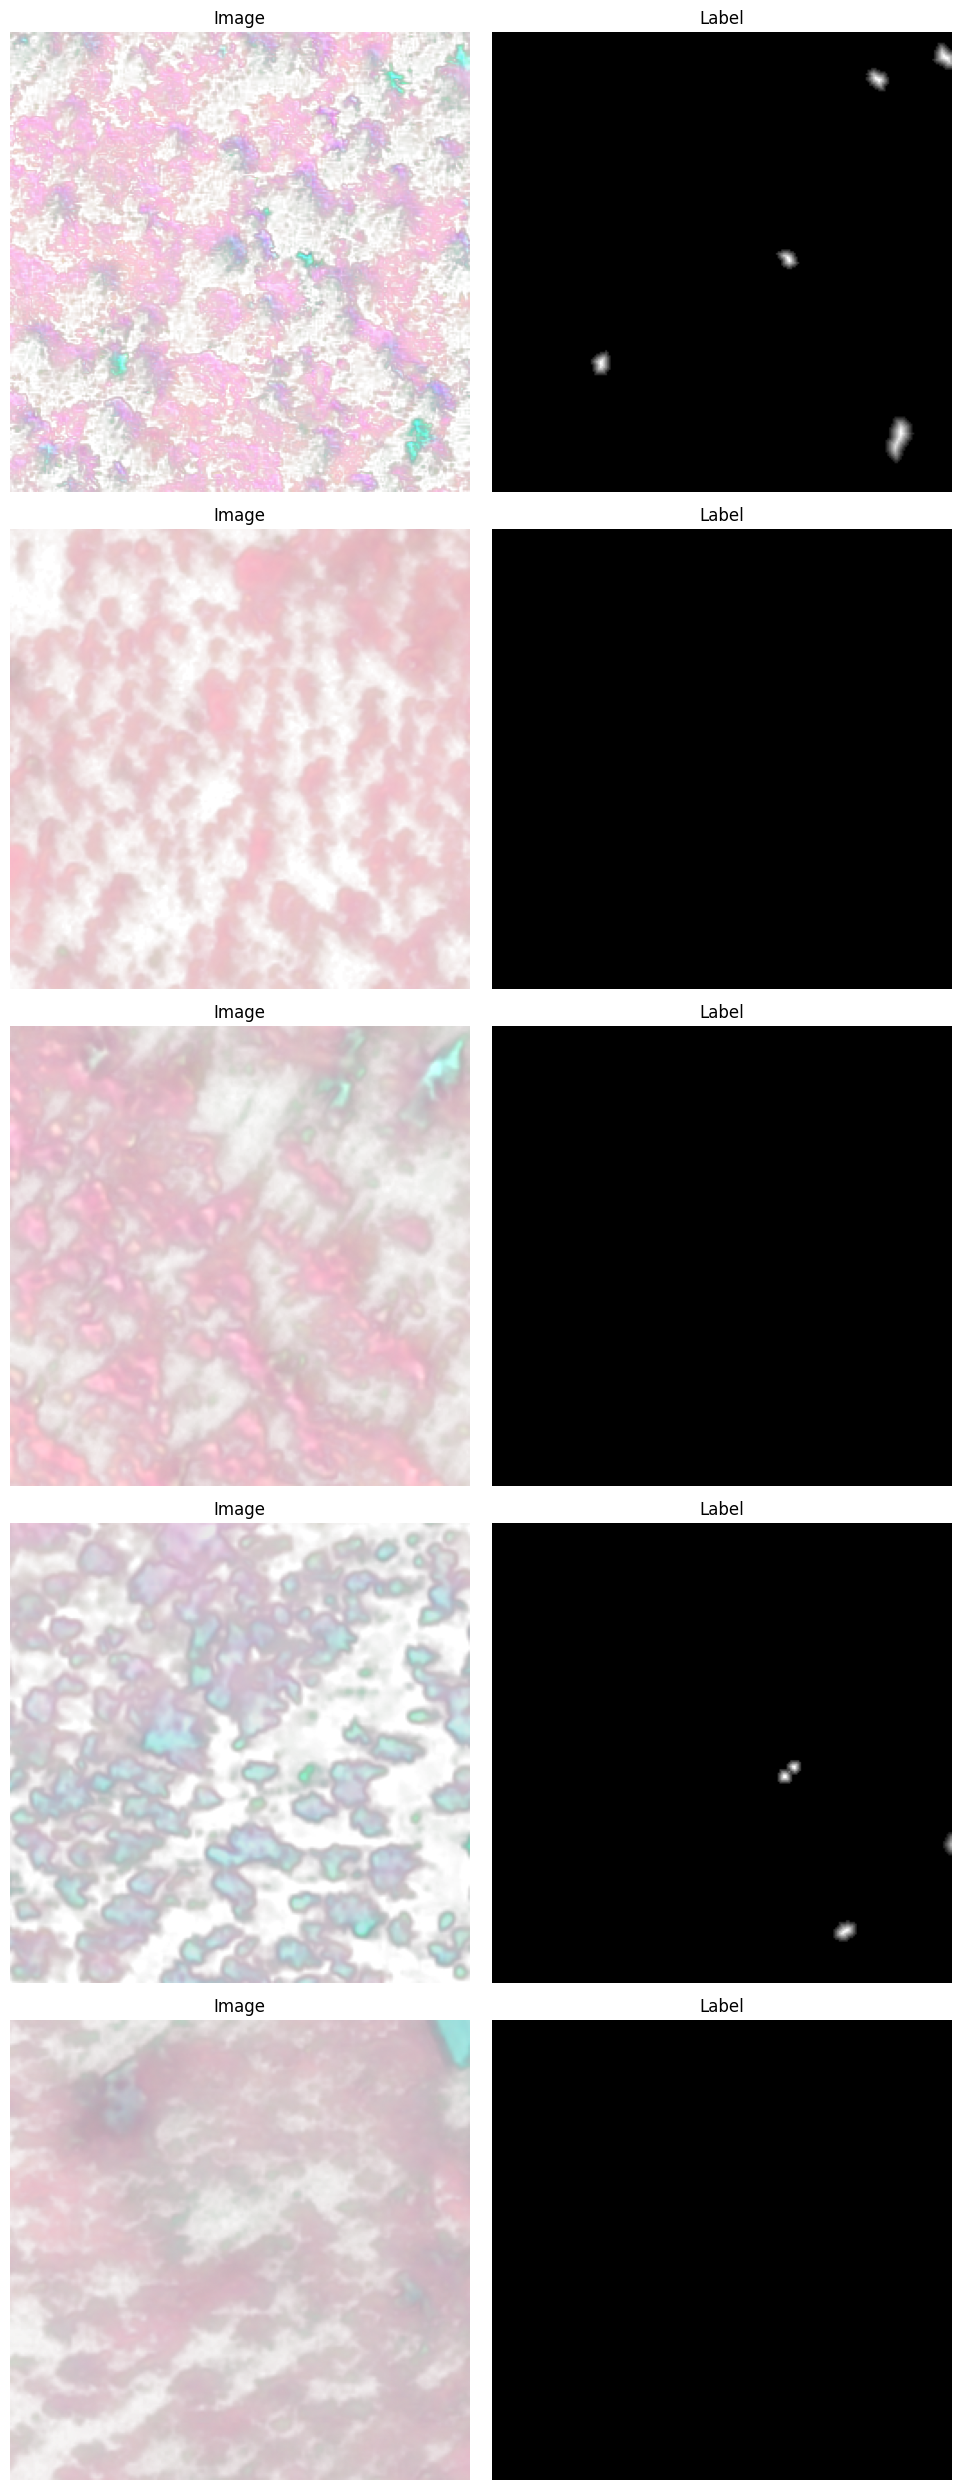

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_samples(dataloader, num_samples=5):
    """
    Plots a few samples from the given dataloader.

    Parameters:
    dataloader (torch.utils.data.DataLoader): The dataloader containing the dataset to visualize.
    num_samples (int): Number of samples to plot.
    """
    model.eval()
    
    # Get a batch of samples
    data_iter = iter(dataloader)
    images, labels = next(data_iter)

    # Convert tensors to numpy arrays for plotting
    images = images.cpu().numpy()
    labels = labels.cpu().numpy()

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))
    
    for i in range(num_samples):
        img = images[i].transpose((1, 2, 0))  # HWC format for plotting
        lbl = labels[i].squeeze()  # HW format for plotting

        # Plot image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')

        # Plot label
        axes[i, 1].imshow(lbl, cmap='gray')
        axes[i, 1].set_title('Label')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Plot samples from the training dataset
plot_samples(train_loader, num_samples=5)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        # Encoder
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(128, 64)
        
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)
        e2 = self.encoder2(F.max_pool2d(e1, kernel_size=2))
        e3 = self.encoder3(F.max_pool2d(e2, kernel_size=2))
        e4 = self.encoder4(F.max_pool2d(e3, kernel_size=2))
        
        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e4, kernel_size=2))
        
        # Decoder
        d4 = self.upconv4(b)
        d4 = torch.cat((self.crop(e4, d4), d4), dim=1)
        d4 = self.decoder4(d4)
        
        d3 = self.upconv3(d4)
        d3 = torch.cat((self.crop(e3, d3), d3), dim=1)
        d3 = self.decoder3(d3)
        
        d2 = self.upconv2(d3)
        d2 = torch.cat((self.crop(e2, d2), d2), dim=1)
        d2 = self.decoder2(d2)
        
        d1 = self.upconv1(d2)
        d1 = torch.cat((self.crop(e1, d1), d1), dim=1)
        d1 = self.decoder1(d1)
        
        out = self.final_conv(d1)
        return out
    
    def crop(self, enc_feat, x):
        """
        Center crop the encoder features to match the dimensions of the upsampled features
        """
        _, _, h, w = x.size()
        enc_feat = torchvision.transforms.functional.center_crop(enc_feat, [h, w])
        return enc_feat

# Instantiate the model
model = UNet(in_channels=4, out_channels=1)

# Print the model architecture
print(model)


UNet(
  (encoder1): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=T

In [5]:
from tqdm import tqdm
import torchvision
import torch.optim as optim

# Hyperparameters
num_epochs = 25
learning_rate = 1e-3

# Set device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the model
model = UNet(in_channels=4, out_channels=1).to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for images, labels in train_loader_tqdm:
        # Move data to the appropriate device
        images = images.to(device)
        labels = labels.to(device).float()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        train_loader_tqdm.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).float()
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    print(f'Validation Loss: {val_loss:.4f}')

# Save the model checkpoint
torch.save(model.state_dict(), 'unet_model.pth')


Epoch [1/25]:   0%|          | 2/738 [01:39<10:11:21, 49.84s/it, loss=0.817]


KeyboardInterrupt: 

In [6]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

# Load the trained model
model = UNet(in_channels=4, out_channels=1).to(device)
model.load_state_dict(torch.load('unet_model.pth'))
model.eval()

# Evaluation function
def evaluate_model(model, dataloader, threshold=0.5):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device).float()

            outputs = model(images)
            preds = torch.sigmoid(outputs) > threshold

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds).astype(int)
    all_labels = np.concatenate(all_labels).astype(int)

    accuracy = accuracy_score(all_labels.flatten(), all_preds.flatten())
    precision = precision_score(all_labels.flatten(), all_preds.flatten())
    recall = recall_score(all_labels.flatten(), all_preds.flatten())
    f1 = f1_score(all_labels.flatten(), all_preds.flatten())

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

# Evaluate the model on the test dataset
evaluate_model(model, test_loader)


FileNotFoundError: [Errno 2] No such file or directory: 'unet_model.pth'

In [ ]:
A = torch.tensor(y_pred, dtype=torch.int)
B = Y_test

id = 1

pred = A[id]
true = B[id]

print(torch.sum(pred), torch.sum(true))

intersection = torch.sum((pred & true).int())
union = torch.sum((pred | true).int())

intersection / union